# KDE Dataset Generation

*Version 1.1.0*

## Purpose

The purpose of this project is to generate a new dataset from an original dataset. The new dataset can be smaller and/or bigger than the original one. Also, the new dataset must be equivalent to the original one, which means that the original information must be kept in the new one.

We assume that the dataset "essence" is contained in the attributes and categories distributions, so we will estimate `Probability Density Functions` (`PDFs`) from the original dataset using `Kernel Density Estimation` (`KDE`). The new dataset will be built from the original `PDFs`.

## Test Dataset Generation

We will build a custom dataset to simplify the analysis, development and testing. This dataset will be considered as the original.

We need a dataset with only one attribute and two categories. Also, the attribute distributions grouped by each category must show a little overlap between them.

We will generate the custom dataset with 200 instances (100 instances per category).

Finally, we will plot the dataset distribution per category. **(Figure 1)**

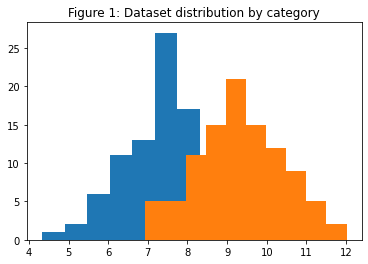

In [1]:
import dataset

# Dataset params
size = 200
n_features = 1
n_categories = 2
seed = 8

# Generate df
df = dataset.generate_dataset(size, n_features, n_categories, seed)

# Plot df
title = "Figure 1: Dataset distribution by category"
dataset.histogram(title, df)


Looking at the chart we can conclude that the custom dataset was properly generated. We can even see the little overlap between distributions.

## KDEs

We need to get the `KDEs` from the dataset distributions to estimate `PDFs`.

We will always generate as many `KDEs` as categories are. We will take instances associated to a specific category and build the `KDE` from them. Each instance will keep all the attributes, that means `KDEs` are multidimensional (one dimension per attribute).

For this case, we will calculate two `KDEs` (1 for category `0`, 1 for category `1`).

In [2]:
import kde 

# Caculate KDEs
kdes = kde.kdes(df)

To make sure `PDFs` estimation are right, we will plot the dataset distributions using the previous calculated `KDEs`. **(Figure 2)**

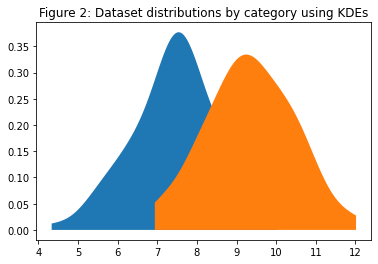

In [3]:
title = "Figure 2: Dataset distributions by category using KDEs"
kde.plot_2d(title, df, kdes)

The distributions represented in the charts are the same, so we conclude that `KDEs` are right.

## First Method

To build the new dataset this method will generate instances randomly and label the new instances using previous `KDEs`.

The possible attributes values of each instance must be contained in intervals (one interval per attribute) which have been calculated from the original values of the attributes.

Once a new instance is generated we will estimate its density using each `KDE`. We will set the label associated to the `KDE` that gives biggest density. We will repeat this process until reach the amount of instances per category which have been defined previously. Instances associate to a category which is full will be discard.

The minimun amount of instances per category is a parameter which depends of the dataset. To optimize this parameter we will need an another study. We will test different values until getting a value that allows to describe correctly each category distribution. We will check it comparing the charts.

We are going to define attributes intervals.

In [4]:
# Get attributes ranges
attributes_ranges = dataset.attributes_ranges(df)

We are going to generate instances and label it until reach the target amount of new instances per category.

In [5]:
# Define amount of new instances per category
n_instances = 1000
# Build nw dataset
new_df = kde.random_generation(n_instances, kdes, attributes_ranges, df.columns, seed)

Now we will plot the new dataset distribution and compare it with the original dataset distributions. **(Figure 3)**

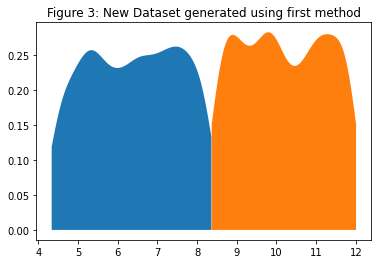

In [6]:
# Calculate new kdes of the new dataset
new_kdes = kde.kdes(new_df)

# Plot new dataset
title = "Figure 3: New Dataset generated using first method"
kde.plot_2d(title, new_df, new_kdes)

The new dataset distributions is significantly different.

We can see that the random instances are well labeled. But if we compare each distributions with the originals, we will see that are not the same.

The reason behind of these differences may be that this method gives the same probability of appearing to all attribute values but in the distributions some values must have more propability of appearing than others.

The current version of this method does not converge.

## Second Method

In this method, we will generate relevant instances for each distribution, we will estimate density (relevancy) for each instance and we will build a dataset which each relevant instance is correctly represented.

We will generate each distribution in a independant way. For each distribution, we will generate relevant instances which be called support. For each instance, we will estimate density using the original `KDE`. The chosen `KDE` will be the associated one to the distribution (groped by category) which is currently being proccesed. This density determines which instances are more significant according to the original distribution so we will build a dataset which more relevant instances will be more represented. To achieve this we will introduce more occurrences of the relevant instances.

There are different ways to generate the support. This topic would require a study to find an efficient method.

We are going to use an exhaustive method which consist in generaing instances to cover the whole distribution space. For example, in our dataset, the attribute interval for category `1` is [7,12] so we will generate equally spaced instances between 7 and 12.

The support adjustment to original distribution can be managed increasing or decreasing the amount of instances. We will call granularity to this parameter. To optimize the granularity we will need a specify study.

To build the support in multivariate dataset cases we will generate each attribute support with the above method and do a cartesian product between all attributes supports.

If we think about exahustive method in a practical way, we will take into account that this method has an unacceptable complexity. So we will need to design more efficient methods in the future.

We are going to generate the support.

In [7]:
# Define granularity
granularity = 100

# Generate supports
new_df = kde.univariate_support(df, granularity)

We are going to estimate density for each instance. We will use the original `KDEs` to achieve this.

In [8]:
# Calculate densities for each instance
densities = kde.estimate_density(new_df, kdes)

Now we know the density for each new instance. That means that we know the representation grade of each new instance according to the original dataset. The goal is to modify the new dataset to get a correct representation for each instance.

There are multiple ways to change instance representations in the dataset.

We are going to increase the amount of the same instance using its density. That means instances with higher density will be appear more than instances with lower density. We will link to the instance with lowest density to an amount of one instance. So, to calculate the amount of duplicate instances for each instance, we are going to divide the instance density between lowest density.

We can think that duplicates instances adding redundant information and so it is. But there is no problem because it is just a method of get the proper representation of the instances. On the other hand, granularity is managed by the instances amount in the support. Nevertheless, there are alternatives to manage instances represention which do not involve duplicate instances. For example, we can search instances neighbours and use them.

We are going to build the new dataset duplicating instances.

In [9]:
# Adjust instance representations in the new dataset
new_df = kde.adjust_representation(densities)

Finally, we are going to plot new dataset and compare it with original dataset. **(Figure 4)**

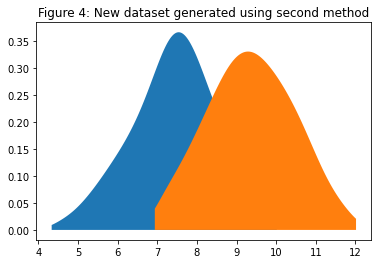

In [10]:
# Plot new df
title = "Figure 4: New dataset generated using second method"
new_kdes = kde.kdes(new_df)
kde.plot_2d(title, new_df, new_kdes)

If we compare the new dataset distributions with the original dataset distributions, we will see that they are the same so we can conclude that this method converges.

The new dataset size is about 2000 instances. The instances amount has increased significantly but it is not very important. This result is mainly due to the representation adjustment method used, which can easily change for another methods which can reduce the number of instances. Even if we can not find a method which give us a smaller dataset directly, we can design another `KDE` based method which can reduce dataset instances. For example, we can combine `KDE` with `MSE` to achieve this.

The most important part of the proposal method is that we can generate an equivalent dataset with different values compared to the original values.

## Multivariate Test Dataset Generation

We need to make sure that the behaviour of `Second Method` (our best proposal) works properly on `Multivariate Test Dataset`

To test the `Second Method` behaviour over multivariate dataset, we are going to generate a multivariate dataset. From this dataset we will generate a synthetic dataset and compare it with the original. The comparative takes into account two factors, shape in charts and model accuracy.

First of all, we will generate a multidimensional dataset which will be considered as original dataset. From this dataset, we will generate a synthetic dataset using the `Second Method`. Over this method, we will make little changes in order to adapt it to multivariate dataset. We will use both dataset to represent and compare them. The shape in both charts must be almost identical. Finally, we will train and test a model (`Naive Bayes`) using a standard way (Stratified Cross Validation over original dataset) and we will build another model which will be train with synthetic dataset and train with original dataset. The accuracy must be similar.

After describing the purpose and the procedure to achieve this, we are going to start generating a new dataset of 200 instances with 2 features and 2 categories, which can be considered as multidimensional dataset. This dataset must have a little overlap between distributions grouped by categories in order to simulate a real dataset which a properly model can obtain a high accuracy but not a perfect accuracy.

We are going to plot the new dataset using an `Scatter Chart` and `3D Chart` to make sure that the dataset meets specifications.

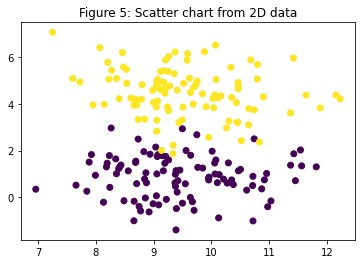

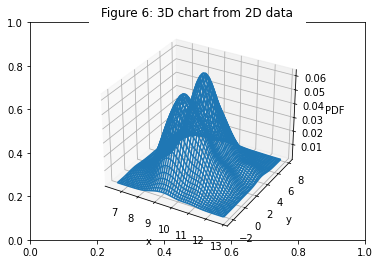

In [11]:
import dataset

# Dataset params
size = 200
n_features = 2
n_categories = 2
seed = 4

# Generate df
df = dataset.generate_dataset(size, n_features, n_categories, seed)

# Plot df
## Scatter Chart
title = "Figure 5: Scatter chart from 2D data"
dataset.scatter(title, df)
## 3D Chart
title = "Figure 6: 3D chart from 2D data"
kde.plot_3d(title, df)


After visualing the dataset, we can conclude that the dataset distribution is binomial and each elevation corresponds with a different category. Besides, we can see that exists a little overlap between both category distributions.

We can conclude that the multivariate dataset have been generated correclty.

Once we have the dataset, we are going to calculate the dataset KDEs, one multivariate KDE (taking into account all attributes) for each category.

The KDEs method is compatible with multivariate dataset so it does not need to make changes.

In [12]:
# Get KDEs from 2D dataset
kdes = kde.kdes(df)

Before building the synthetic dataset it is necessary to make a first dataset which will be use as an approach.

This approach will contain all necessary instances to describe the multidimensional space of the original dataset `PDF`.

To generate this, we will create a support for each attribute, which will be determined by the min and max value and the granularity. Granularity specifies the number of point between the min and max value, these points are equispaced. With these supports, we will generated all combinations between all of them (cartesian product) and each combination will be considered a instance.

We need to design a new method to achieve this purpose since method for univariate dataset is not compatible with our multivariate dataset. In one dimension it is not necessary the cartesian product.

In our case, we are choose an arbitrary granularity value. This value allows describe the multidimensional space and is not too big to be computed.

In [13]:
# Define granularity
granularity = 100

# Generate new df
new_df = kde.multivariate_dataset(df, granularity)

The current new dataset will be use as base to make the final synthetic dataset.

To build the final dataset we need to balance our instances in such way that each instance is correctly represented according to original dataset. That means that some instances should be have more weight than the others.

We need to know how much "weight" has each instance. To know this we will use the density which will be calculated using the original KDEs.

This methods is compatible with multidimensional dataset.

In [14]:
# Calculate densities for each instance
new_df = kde.estimate_density(new_df, kdes)

Once we have all densities, we will use them to adjust each instance representation.

The method will be simple, we will duplicate each instances proportionally taking into account we will define the next relationship, density of the instance which belong to the 50th percentile will be equal to one instance. That means all instances which its density will be lower than reference density will be removed. Instances which its density will be bigger than the reference density will be duplicated under this relationshiop, n_instances = round(instance_density/reference_density). The percentile value have been chosen arbitrarily, this value could not be the optimal and the optimal can change between datasets.

We need to design a new method to adjust a multivariate dataset since univariate method is not compatible. Univarite method take as density reference the minimun instance density. If we use that criteria here, the time to compute the algorithm and the size of the synthetic dataset will be too high.

In [15]:
# Adjust instance representations in the new dataset
new_df = kde.multivariate_adjust_representation(new_df)

We have already generate the synthetic dataset. Now, we are going to test the shape of the multidimensional pdf.

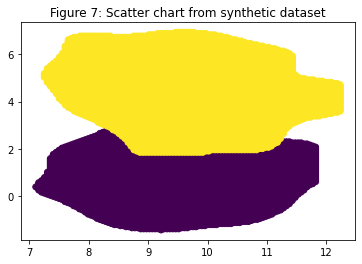

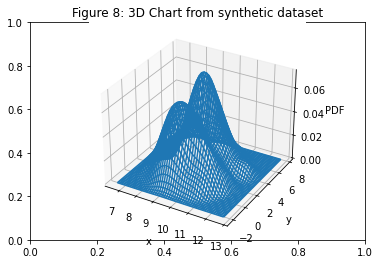

In [16]:

# Plot dataset
## Scatter Chart
title = "Figure 7: Scatter chart from synthetic dataset"
dataset.scatter(title, new_df)
## 3D Chart
title = "Figure 8: 3D Chart from synthetic dataset"
kde.plot_3d(title, new_df)


We can not visualize points on `Scatter Chart`. Instead of this, we can visualize an area which match with the imaginary area which is described on `Scatter Chart` of the original dataset. That makes sense, all this area in the synthetic dataset is cover by points so we can see them. But there are some regions inside of this area which have more density than others. This fact can be visualized on `3D chart`.

We can conclude that synthetic dataset is generated properly.

Now, we are going to test the predictive capacity of a model which is trained using the synthetic dataset instead of using the traditionals method.

To test it, we are going to compare the accuracy of a model trained using `Stratified Cross Validation` and the accuracy of a model trained with the synthetic dataset.

The model we will choose to the test is `Naive Bayes`.

In [17]:
# Supervised learning using Stratified Cross Validation and naive bayes as model
mean, std = dataset.scv(df)
# Parse to percent
mean *= 100
std *= 100

print(f"Accuracy: {mean:.2f}%; Std:  {std:.2f}%")

Accuracy: 95.50%; Std:  4.72%


In [18]:
# Supervised learning using the synthetic dataset to train the naive bayes model and the original dataset to test it.
accuracy = dataset.holdout(df, train_df=new_df)
# Parse to percent
accuracy *= 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.00%


The accuracy using both method is similar.

We can conclude using a synthetic dataset to train models it is an alternative with the same quality as the traditional methods at predictive level. Nevertheless, using an synthetic dataset can some problems which are present in traditional methods, even can solve primitive problems linked to the data collection between other uses.

However, the method to generate a synthetic dataset (KDE based) is not useful in a real situation. The computational cost of the algorithm is so high.

From this document, we have take into account that generate a synthetic dataset which have different values but keeps a very similar pdf to the pdf of the original dataset can have a lot of interesting applications. Using the KDE to build the orignal PDF looks like a good method. The problem is on generating samples from the PDF. Fortunately, there are some mathematical methods to achieve this. The most fundamental is `Inverse Transform Sampling` and after some research it looks like that this methods can be applied in our case.